In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import os
for dirname, _, filenames in os.walk('C:/Users/ID/Documents/jupyter-notebook'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [9]:
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from numpy import nan
from pathlib import Path
from operator import itemgetter
from catboost import CatBoostClassifier

In [10]:
def score(model):
    p_train = model.predict(X_train)
    print(classification_report(p_train, y_train))
    print(f1_score(y_train, p_train))
    p_test = model.predict(X_test)
    print(classification_report(p_test, y_test))
    print(f1_score(y_test, p_test))

In [13]:
dataroot = Path('C:/Users/ID/Documents/jupyter-notebook')

In [14]:
TARGET = 'Credit Default'

In [22]:
df_train = pd.read_csv(dataroot / 'course_project_train.csv')
df_train.shape

(7500, 17)

In [23]:
df_pred = pd.read_csv(dataroot / 'course_project_test.csv')
df_pred.shape

(2500, 16)

In [24]:
df = pd.concat( [df_train.drop(TARGET, axis=1), df_pred]).reset_index(drop=True)
df.shape

(10000, 16)

<AxesSubplot:xlabel='Credit Score', ylabel='Credit Default'>

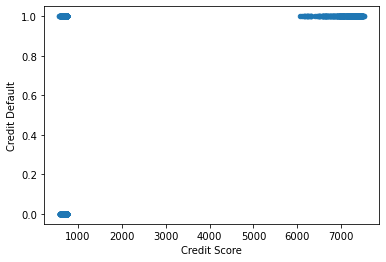

In [25]:
df_train.plot(x='Credit Score', y=TARGET, kind='scatter')

In [26]:
ii = df['Credit Score']>5000
df['Big Score'] = 0
df.loc[ii, 'Big Score'] = 1
df.loc[ii, 'Credit Score'] *= 0.1

<AxesSubplot:>

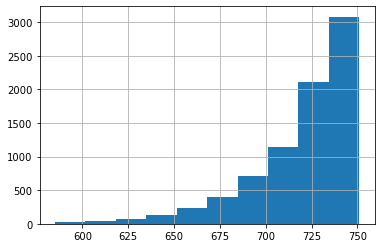

In [27]:
df['Credit Score'].hist()

<AxesSubplot:xlabel='Current Loan Amount', ylabel='Credit Default'>

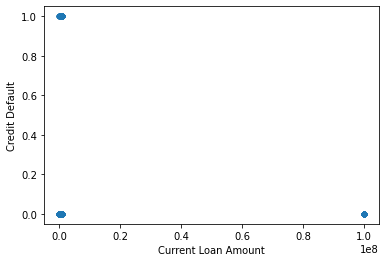

In [28]:
df_train.plot(x='Current Loan Amount', y=TARGET, kind='scatter')

In [29]:
ii = df['Current Loan Amount'] > 5e7
df['Big Loan'] = 0
df.loc[ii, 'Big Loan'] = 1
df.loc[ii, 'Current Loan Amount'] = nan

In [30]:
years_dict = {'10+ years':10, '8 years':8, '6 years':6, '7 years':7, '5 years':5, '1 year':1,
       '< 1 year':0, '4 years':4, '3 years':3, '2 years':2, '9 years':9}

In [31]:
df.replace({'Years in current job':years_dict}, inplace=True)

In [32]:
cat_rep = {col: {k: v for v, k in enumerate(df[col].unique())} for col in df.select_dtypes(object).columns}
cat_rep

{'Home Ownership': {'Own Home': 0,
  'Home Mortgage': 1,
  'Rent': 2,
  'Have Mortgage': 3},
 'Purpose': {'debt consolidation': 0,
  'other': 1,
  'home improvements': 2,
  'take a trip': 3,
  'buy a car': 4,
  'small business': 5,
  'business loan': 6,
  'wedding': 7,
  'educational expenses': 8,
  'buy house': 9,
  'medical bills': 10,
  'moving': 11,
  'major purchase': 12,
  'vacation': 13,
  'renewable energy': 14},
 'Term': {'Short Term': 0, 'Long Term': 1}}

In [33]:
df.replace(cat_rep, inplace=True)

In [34]:
imp = IterativeImputer(random_state=0)
df = pd.DataFrame(imp.fit_transform(df), columns=df.columns)

In [35]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Big Score,Big Loan
0,0.0,482087.0,7.437576,0.0,11.0,26.3,685960.0,1.0,39.916256,1.0,0.0,0.0,198876.564849,47386.0,7914.0,749.0,0.0,1.0
1,0.0,1025487.0,10.000000,0.0,15.0,15.3,1181730.0,0.0,33.220391,0.0,0.0,1.0,264968.000000,394972.0,18373.0,737.0,0.0,0.0
2,1.0,751412.0,8.000000,0.0,11.0,35.0,1182434.0,0.0,33.861186,0.0,0.0,0.0,255199.030251,308389.0,13651.0,742.0,0.0,1.0
3,0.0,805068.0,6.000000,0.0,8.0,22.5,147400.0,1.0,39.459119,1.0,0.0,0.0,121396.000000,95855.0,11338.0,694.0,0.0,0.0
4,2.0,776264.0,8.000000,0.0,13.0,13.6,385836.0,1.0,38.148432,0.0,0.0,0.0,125840.000000,93309.0,7180.0,719.0,0.0,0.0


###### CatBoost не работает, если категории во float, поэтому переводим их в int

In [37]:
catcols = [
    'Home Ownership', 'Years in current job', 'Tax Liens',
    'Number of Open Accounts', 'Number of Credit Problems','Months since last delinquent',
    'Bankruptcies', 'Purpose', 'Term']

In [38]:
df[catcols] = df[catcols].astype(int)

In [39]:
X = df.iloc[:7500]

In [40]:
y = df_train[TARGET]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)

In [42]:
cat_cls = CatBoostClassifier(
    class_weights=[1, 3],
    verbose=False)
cat_cls.fit(X_train, y_train, cat_features=catcols)
score(cat_cls)

              precision    recall  f1-score   support

           0       0.75      0.93      0.83      3470
           1       0.85      0.57      0.68      2530

    accuracy                           0.78      6000
   macro avg       0.80      0.75      0.75      6000
weighted avg       0.79      0.78      0.77      6000

0.680568720379147
              precision    recall  f1-score   support

           0       0.68      0.85      0.76       867
           1       0.69      0.46      0.55       633

    accuracy                           0.69      1500
   macro avg       0.69      0.66      0.66      1500
weighted avg       0.69      0.69      0.67      1500

0.553030303030303
